# Modelo de fallas cardiacas

*   Flores Callejas Arturo - arturo02@ciencias.unam.mx
* Trejo Lopez Edgar Armando - edtrelo@ciencias.unam.mx



In [ ]:
pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.7/414.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=538e7d92494c89e96e458555cea9e7f1ef25ec0b968913ea6ebd24c93e958ffe
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
#Se importan las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.utils import resample
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVR, SVC
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import prince # en colab es necesario instalar
import lightgbm as lgb
import eli5 # en colab es necesario instalar
from eli5.sklearn import PermutationImportance
from matplotlib.colors import Normalize
sns.set(style='ticks')
import warnings
warnings.filterwarnings('ignore')

## Construcción de la ABT y EDA

La tabla no necesita limpieza, todas las variables son útiles y están en el formato correcto.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/ArturoFC02/Heart-Failure-predictive-model/refs/heads/main/heart.csv',
                   dtype = {'HeartDisease':str, 'FastingBS':str})
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    object 
dtypes: float64(1), int64(4), object(7)
memory usage: 86.2+ KB


Dado que `HeartDisease` es la variable respuesta que queremos clasificar, será de utilidad llamarla `target` en la tabla.

In [ ]:
data.rename(columns = {'HeartDisease':'target'}, inplace = True)

In [ ]:
data.target.value_counts(normalize=True).round(3)

1    0.553
0    0.447
Name: target, dtype: float64

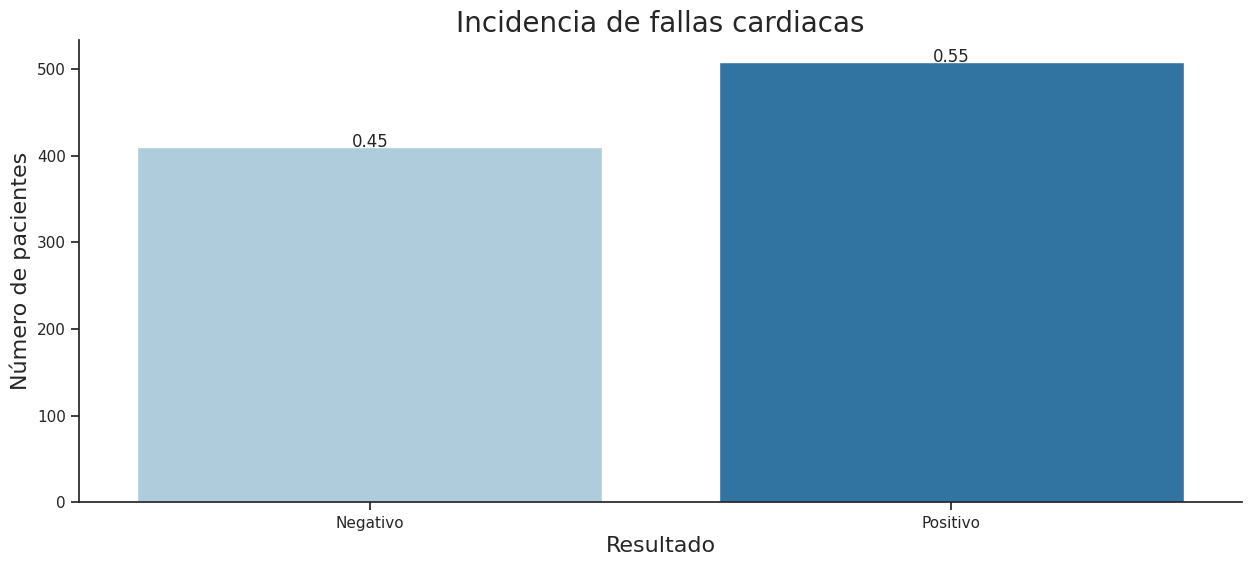

In [ ]:
plt.figure(figsize = (15,6))

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

sns.set_palette(sns.color_palette('Paired'))

total = float(len(data))
results = ['Negativo', 'Positivo']
ax = sns.countplot(x='target', data=data)
ax.set_xticklabels(results)

# add percentages above each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            p.get_height(),
            '{:1.2f}'.format(height/total),
            ha='center')

plt.title('Incidencia de fallas cardiacas', fontsize=20)
plt.xlabel('Resultado')
plt.ylabel('Número de pacientes')

sns.set(style='ticks')
sns.despine()

In [ ]:
col_num = data.select_dtypes(exclude = ['object']) # variables categóricas, aquí se incluyó al target
col_cat = data.select_dtypes(include = ['object']) # variables numéricas

del col_cat['target']

### Null Handling

In [ ]:
data.isna().sum() # no hay datos nulos.

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
target            0
dtype: int64

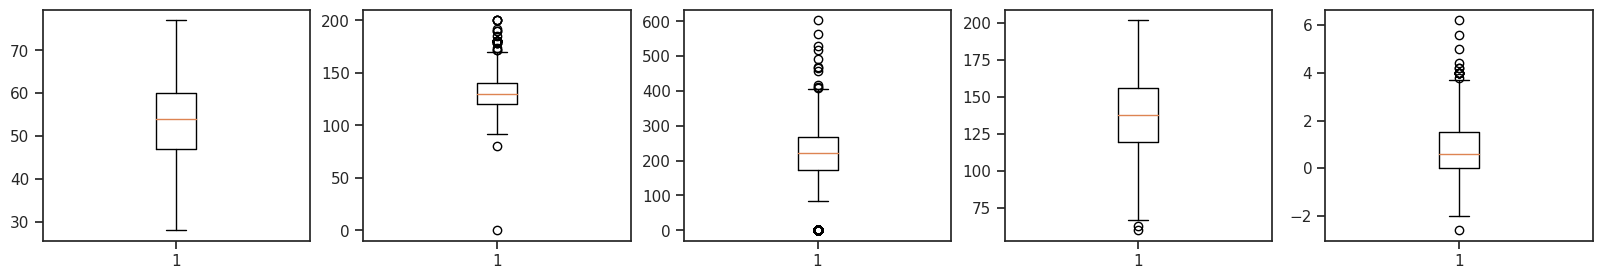

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (20, 3))

for i in range(5):
  ax[i].boxplot(data[col_num.columns[i]])


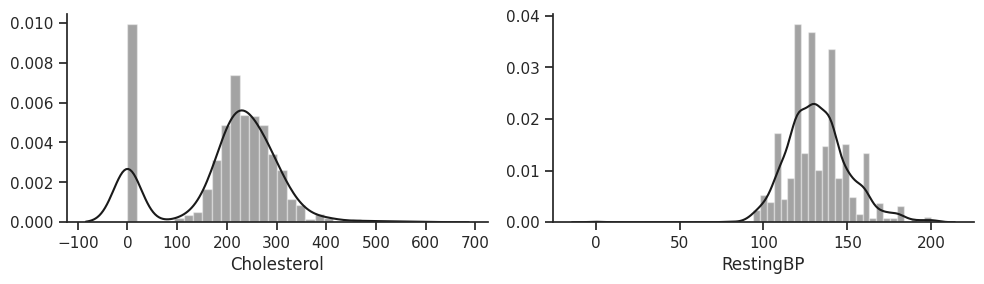

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

nulos = ["Cholesterol", "RestingBP"]

for i in range(2):
  sns.distplot(data[nulos[i]], color = 'k', ax = axs[i])
  axs.ravel()[i].set_ylabel("")
  axs.ravel()[i].spines[['top', 'right']].set_visible(False)


plt.tight_layout()
plt.show()

Hay 172 valores "nulos" en `Cholesterol` y uno en ``

In [ ]:
(data['Cholesterol'] == 0).sum(), (data['RestingBP'] == 0).sum()

(172, 1)

In [ ]:
## se sustituye data['RestingBP'] == 0 por la media
mediaRBP = data[data['RestingBP'] != 0]['RestingBP'].mean()
data['RestingBP'] = data['RestingBP'].replace(0, mediaRBP)

In [ ]:
data['Cholesterol'] = data['Cholesterol'].replace(0, np.nan)

In [ ]:
# Coeficientes de correlación antes de la transformación
data.corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.263081,0.058758,-0.382045,0.258612
RestingBP,0.263081,1.000000,0.095939,-0.109662,0.174220
Cholesterol,0.058758,0.095939,1.000000,-0.019856,0.058488
MaxHR,-0.382045,-0.109662,-0.019856,1.000000,-0.160691
Oldpeak,0.258612,0.174220,0.058488,-0.160691,1.000000


In [ ]:
data.to_csv('datawtNA.csv')

Aquí va la implementación del método `missForest` en R para la tabla. Una vez obtenida la solución, la importamos:

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/edtrelo/TM/main/ProyectoFinal/dataimp.csv',
                   dtype = {'target':str, 'FastingBS':str})

In [ ]:
data.corr()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
Age,1.000000,0.263081,0.042556,-0.382045,0.258612
RestingBP,0.263081,1.000000,0.106308,-0.109662,0.174220
Cholesterol,0.042556,0.106308,1.000000,-0.015898,0.054619
MaxHR,-0.382045,-0.109662,-0.015898,1.000000,-0.160691
Oldpeak,0.258612,0.174220,0.054619,-0.160691,1.000000


In [ ]:
antes = np.array([0.058758,	0.095939, -0.019856, 0.058488])

desp = np.array([0.042556,	0.106308,	-0.015898,	0.054619])

In [ ]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,target
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    float64
 4   Cholesterol     918 non-null    float64
 5   FastingBS       918 non-null    object 
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  target          918 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 86.2+ KB


In [ ]:
col_num = data.select_dtypes(exclude = ['object']) # variables categóricas, aquí se incluyó al target
col_cat = data.select_dtypes(include = ['object']) # variables numéricas

del col_cat['target']

In [ ]:
ABT_positive = data.loc[data['target'] == '1']
ABT_negative = data.loc[data['target'] == '0']

## función para generar el gráfico de densidades de una columna
def distplot(col, ax, xlabel):
  #Densidad de casos por edades
  global ABT_positive
  global ABT_negative

  plt.rcParams['axes.titlesize'] = 20
  plt.rcParams['axes.labelsize'] = 16
  plt.rcParams['axes.titlesize'] = 16

  five_thirty_eight = [
    '#30a2da',
    '#fc4f30',
    '#e5ae38',
    '#6d904f',
    '#8b8b8b',
  ]

  sns.set_palette(sns.color_palette(five_thirty_eight))

  sns.distplot(ABT_positive[col], label='Casos positivos', ax = ax)
  sns.distplot(ABT_negative[col], label='Casos negativos', ax = ax)

  sns.set(style='ticks')
  ax.legend()
  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel("", fontsize = 16)
  sns.despine()

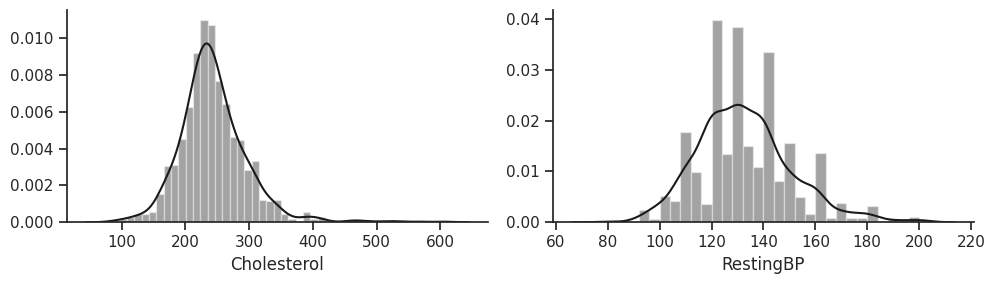

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

cols = ['Cholesterol', 'RestingBP']

for i in range(2):
  sns.distplot(data[cols[i]], color = 'k',
               label = 'Distribución original', ax = axs.ravel()[i])
  axs.ravel()[i].set_ylabel("")
  axs.ravel()[i].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

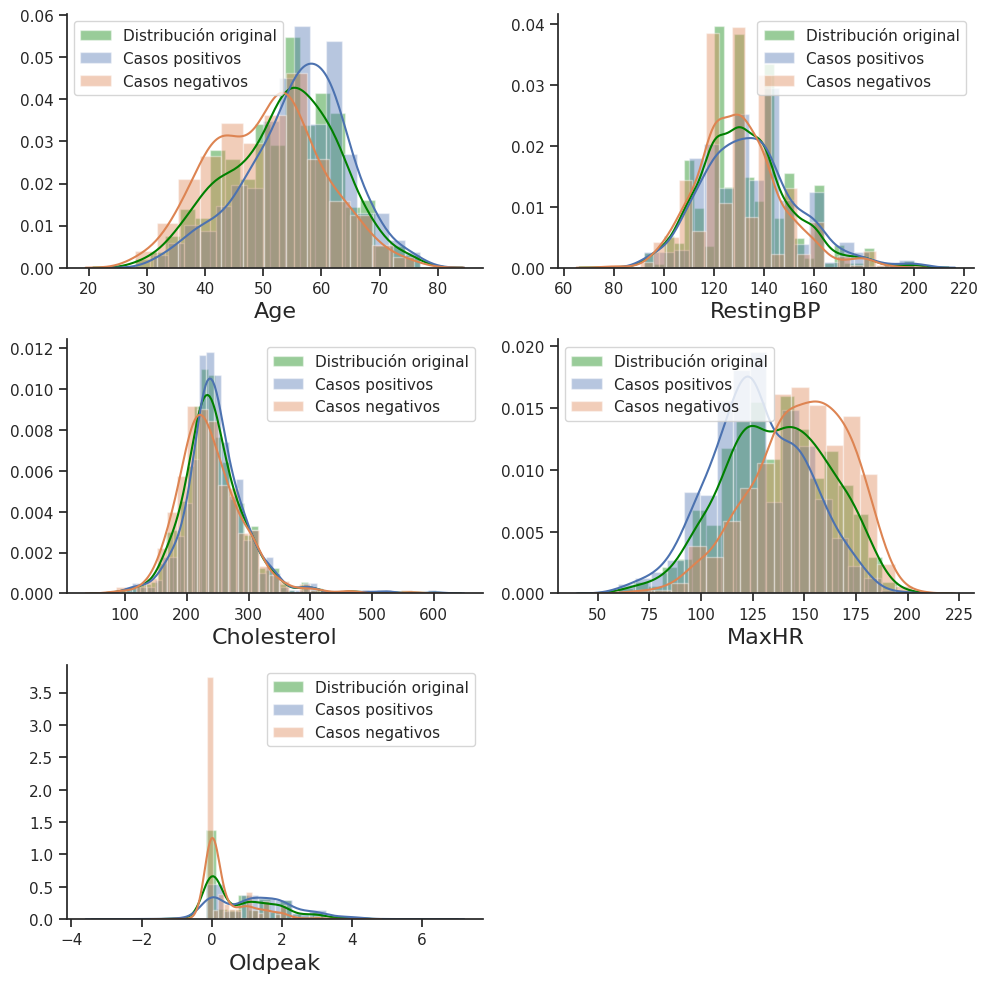

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))

for i in range(5):
  sns.distplot(data[col_num.columns[i]], color = 'green',
               label = 'Distribución original', ax = axs.ravel()[i])
  distplot(col_num.columns[i], axs.ravel()[i], col_num.columns[i])

axs[2,1].axis('off')

plt.tight_layout()
plt.show()

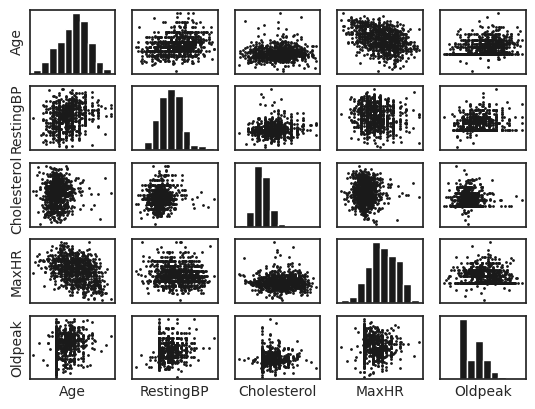

In [ ]:
## gráficos de dispersión

fig, ax = plt.subplots(5, 5)

for i in range(5):
  for j in range(5):
    if i == j:
      ax[i, j].hist(col_num.iloc[:, i], color = 'k')
    else:
      ax[i, j].scatter(col_num.iloc[:, i], col_num.iloc[:, j], c = 'k', s = 1)
    ax[i, j].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,    # ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

for i in range(5):
  ax[i, 0].set_ylabel(col_num.columns[i], fontsize = 10)
  ax[4, i].set_xlabel(col_num.columns[i], fontsize = 10)

plt.show()

In [ ]:
col_num.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.540894,243.851197,136.809368,0.887364
std,9.432617,17.989932,53.918360,25.460334,1.066570
min,28.000000,80.000000,85.000000,60.000000,-2.600000
25%,47.000000,120.000000,213.000000,120.000000,0.000000
50%,54.000000,130.000000,237.834423,138.000000,0.600000
75%,60.000000,140.000000,269.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


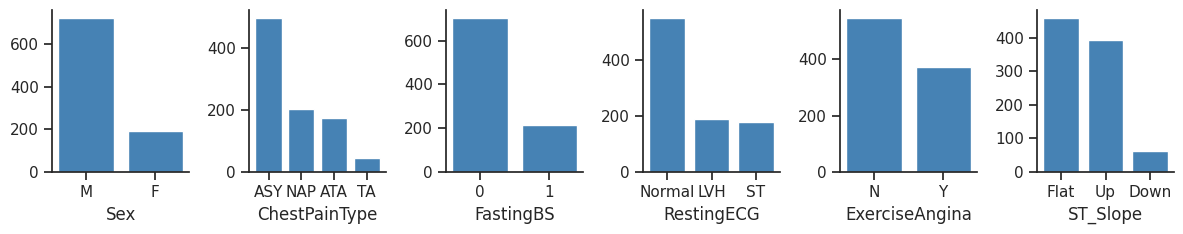

In [ ]:
fig, axs = plt.subplots(1, 6, figsize = (12, 2.5))

for i in range(6):
  ax = axs.ravel()[i]
  x, y = col_cat.iloc[:, i].value_counts().index, col_cat.iloc[:, i].value_counts()
  ax.bar(x, y, color = 'steelblue')
  ax.set_xlabel(col_cat.columns[i], fontsize = 12)
  ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
def indextostr(x):
  return '_'.join(list(x))

In [ ]:
conteox = col_cat.value_counts().index.to_numpy()
y = col_cat.value_counts().to_numpy()
x = list(map(indextostr, conteox))

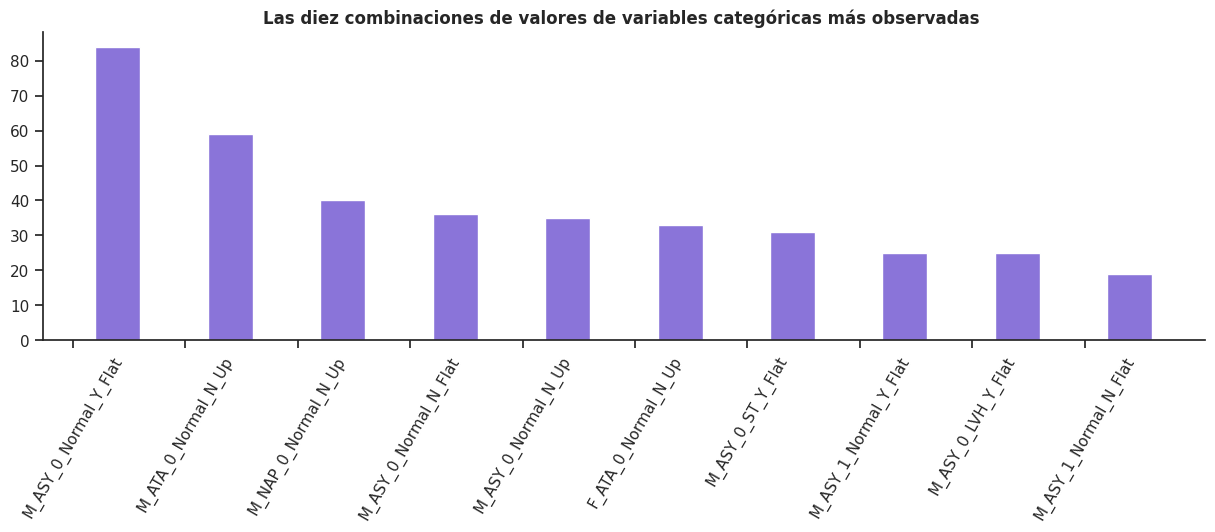

In [ ]:
fig, ax = plt.subplots(figsize = (15, 4))

ax.bar(x[:10], y[:10], color = '#8A74D9', width = 0.4)
ax.spines[['top', 'right']].set_visible(False)

t = ax.get_xticks()
ax.set_xticks(np.array(t)-0.4)
ax.set_xticklabels(x[:10], rotation = 60)

plt.title('Las diez combinaciones de valores de variables categóricas más observadas ', fontweight ="bold")
plt.show()

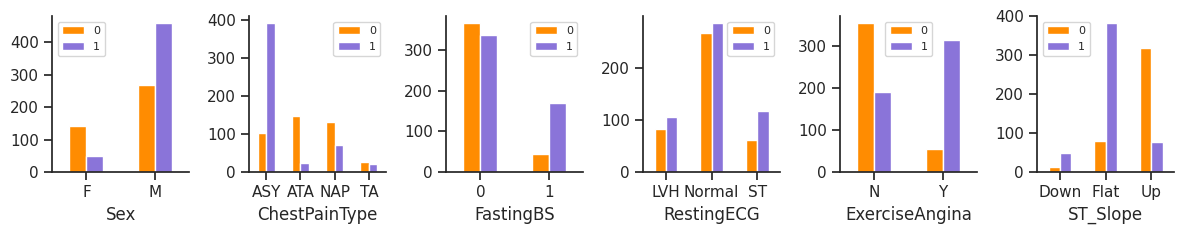

In [ ]:
fig, axs = plt.subplots(1, 6, figsize = (12, 2.5))

for i, c in enumerate(col_cat.columns):
  ax = axs.ravel()[i]
  df = pd.crosstab(data[c], data['target'])
  df.plot.bar(ax = ax, color = ['#FF8C01', '#8A74D9'])
  ax.legend(prop={'size':8})
  t = ax.get_xticklabels()
  ax.set_xticklabels(t, rotation = 0)
  ax.spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

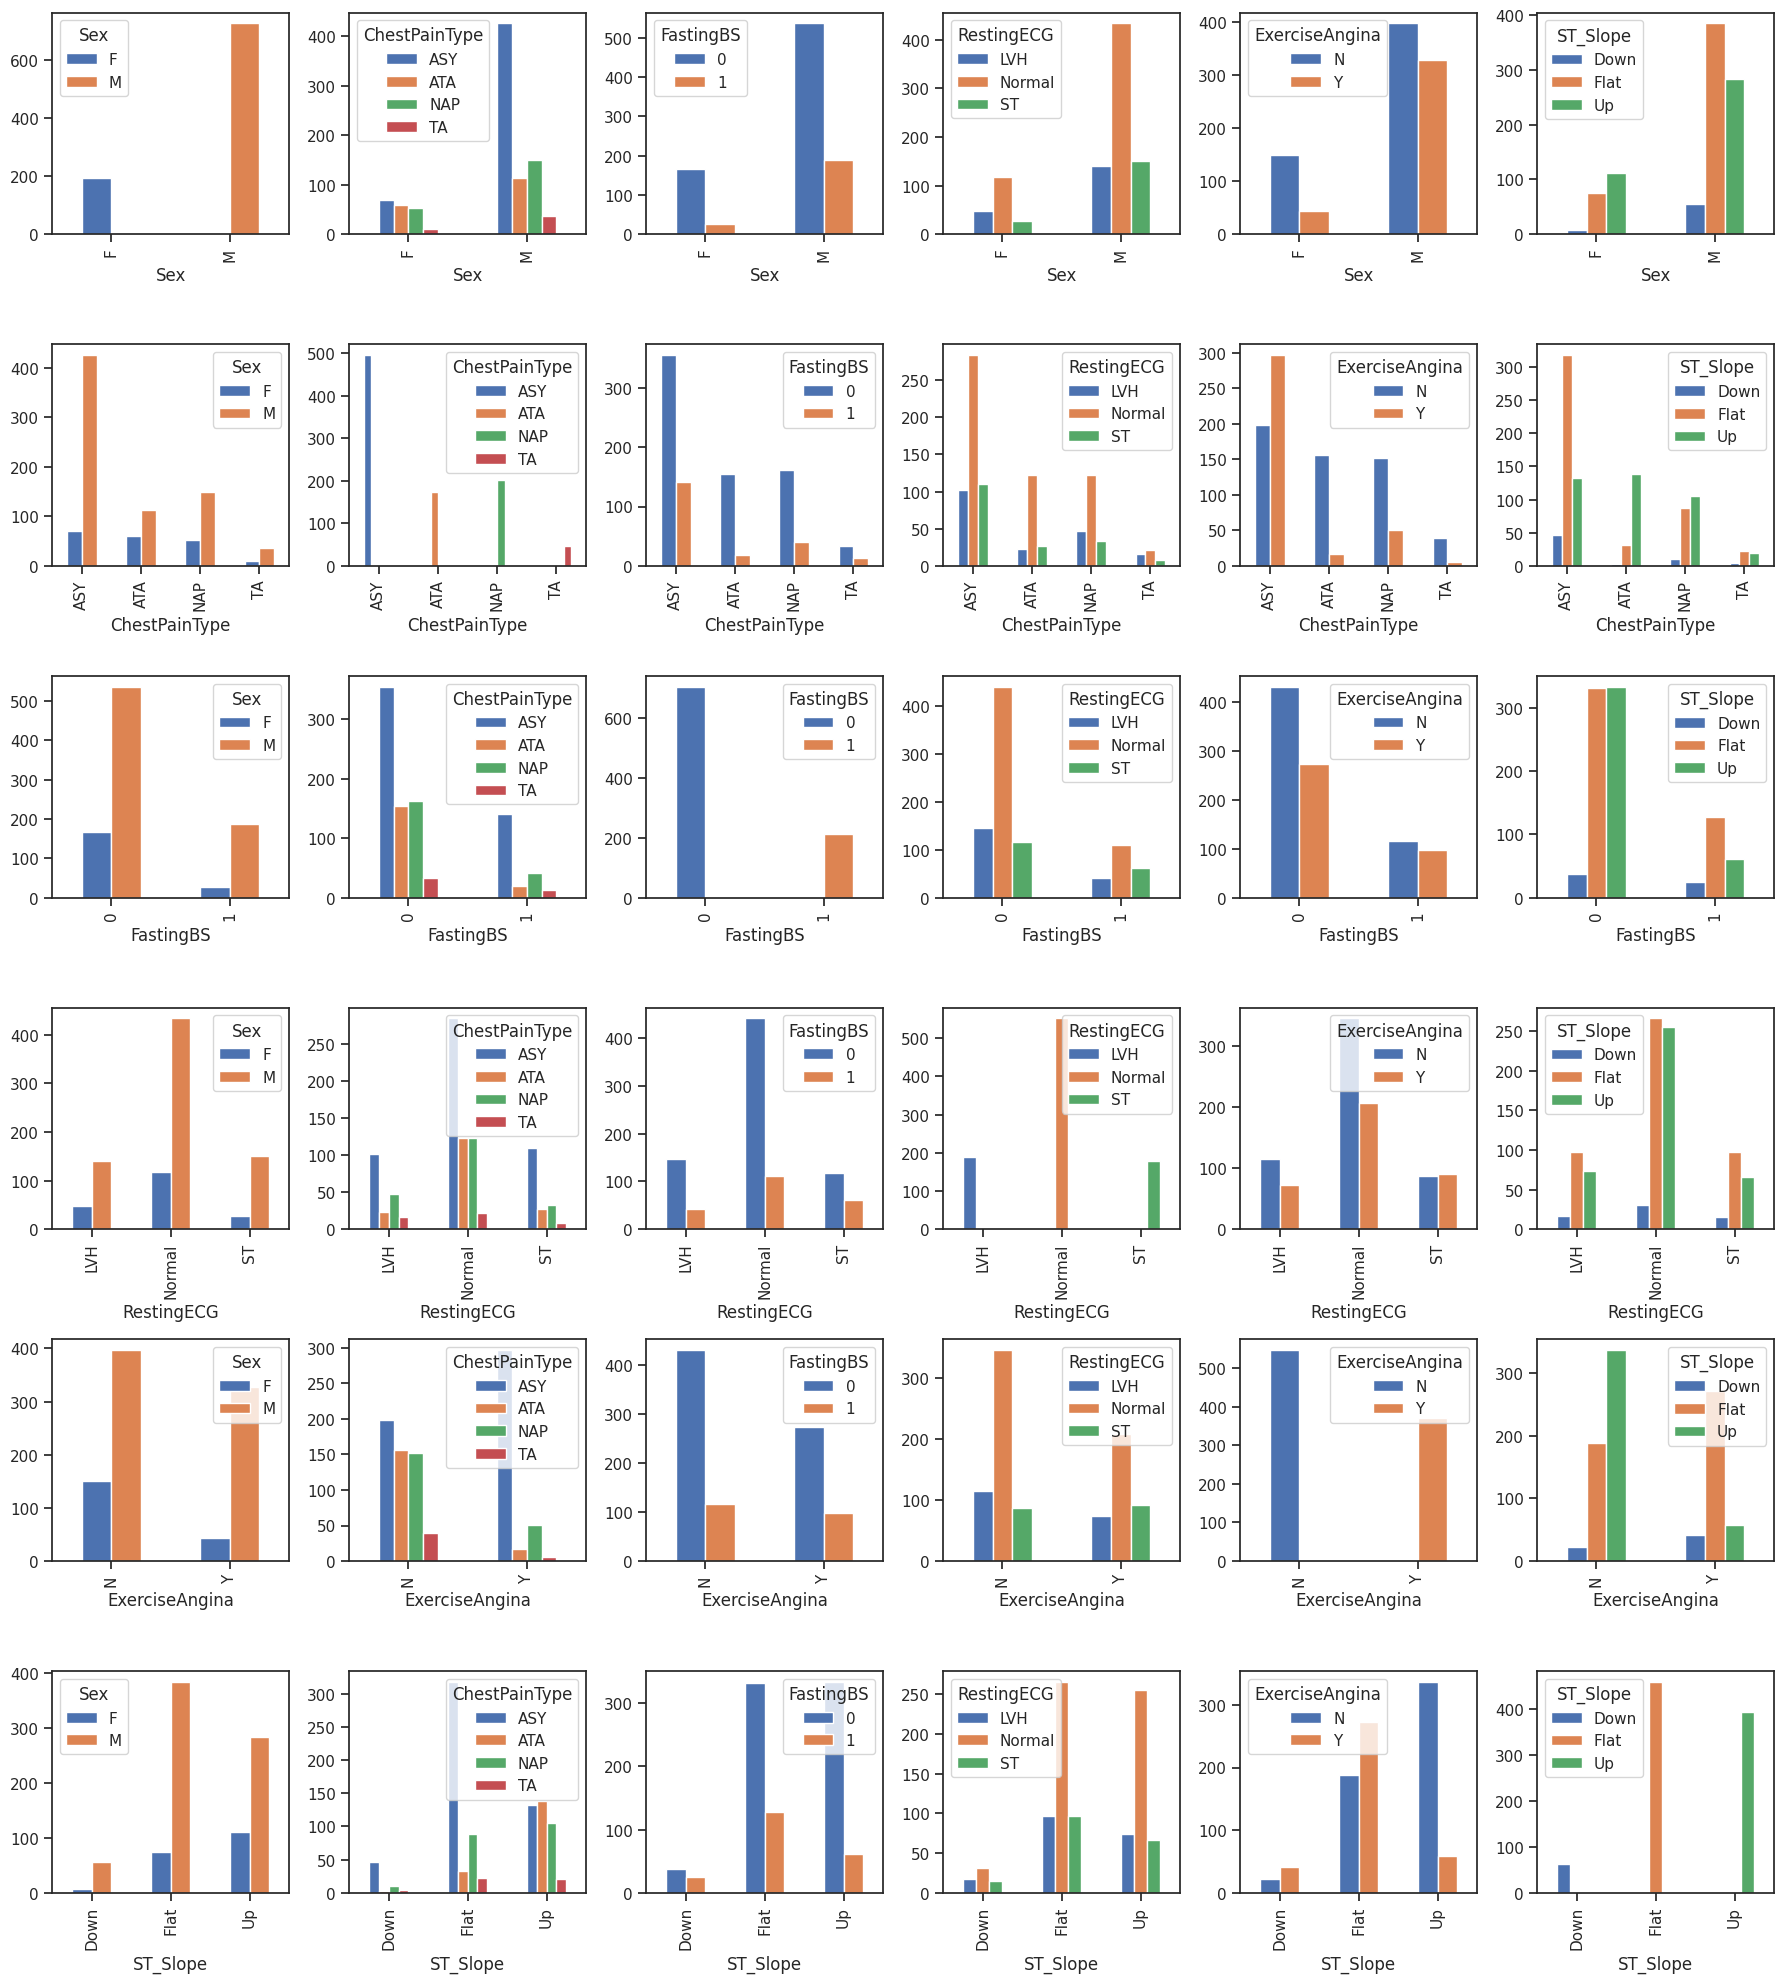

In [ ]:
fig, ax = plt.subplots(6, 6, figsize = (18, 20))

for i in range(6):
  for j in range(6):
    df = pd.crosstab(col_cat.iloc[:, i], col_cat.iloc[:, j])
    df.plot.bar(ax = ax[i, j])

plt.tight_layout()
plt.show()

In [ ]:
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP         float64
Cholesterol       float64
FastingBS          object
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
target             object
dtype: object

## Análisis Estadístico


In [ ]:
# independencia de variables categóricas
# Chi square test

### Matriz de Correlación

In [ ]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = stats.chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return np.sqrt(stat/(obs*mini))

In [ ]:
col_cat_en = col_cat.copy()

In [ ]:
for c in col_cat_en.columns:
  col_cat_en[c] = LabelEncoder().fit_transform(col_cat_en[c])

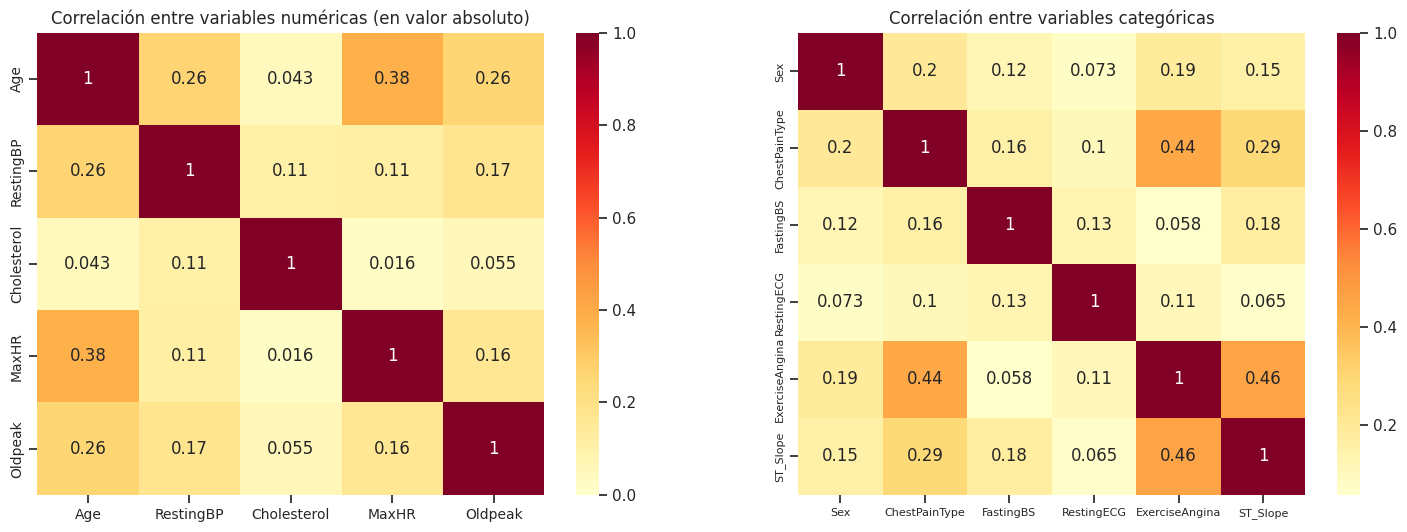

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))

# ------------- correlación numéricas ---------------------------- #
corr_matrix = col_num.corr()
sns.heatmap(corr_matrix.apply(abs),
            cmap = "YlOrRd",
            annot = True, ax = ax[0], norm=Normalize(vmin = 0, vmax = 1))
ticks = corr_matrix.columns
ax[0].set_yticks(np.arange(len(ticks)) + 0.5)
ax[0].set_yticklabels(ticks, fontsize = 10)

ax[0].set_xticks(np.arange(len(ticks)) + 0.5)
ax[0].set_xticklabels(ticks, fontsize = 10)

ax[0].set_title('Correlación entre variables numéricas (en valor absoluto)')


# ------------- correlación categóricas ---------------------------- #
corr_cat = col_cat_en.corr(method = cramers_V)
sns.heatmap(corr_cat, cmap = "YlOrRd", annot = True, ax = ax[1])
ticks = corr_cat.columns
ax[1].set_yticks(np.arange(len(ticks)) + 0.5)
ax[1].set_yticklabels(ticks, fontsize = 8, rotation = 90)

ax[1].set_xticks(np.arange(len(ticks)) + 0.5)
ax[1].set_xticklabels(ticks, fontsize = 8, rotation = 0)

ax[1].set_title('Correlación entre variables categóricas')

plt.show()

### Normalidad

In [ ]:
# ajuste a curva normal de cada
for c in col_num.columns:
  x = data[c]
  print(stats.shapiro(x)) # ninguna se distribuye normal

ShapiroResult(statistic=0.9910141825675964, pvalue=2.170366860809736e-05)
ShapiroResult(statistic=0.971276044845581, pvalue=1.7471388918943731e-12)
ShapiroResult(statistic=0.9214844703674316, pvalue=1.90476753733661e-21)
ShapiroResult(statistic=0.9926717877388, pvalue=0.0001683219597907737)
ShapiroResult(statistic=0.8598772287368774, pvalue=8.26949925434661e-28)


In [ ]:
for c in col_num.columns:
  x = data[c]
  print(stats.shapiro(np.log(x))) # ninguna se distribuye normal

ShapiroResult(statistic=0.9681519865989685, pvalue=2.77636502113085e-13)
ShapiroResult(statistic=0.9883162379264832, pvalue=1.0874017561945948e-06)
ShapiroResult(statistic=0.9712967872619629, pvalue=1.7693219936040783e-12)
ShapiroResult(statistic=0.9705399870872498, pvalue=1.1196862664472618e-12)
ShapiroResult(statistic=nan, pvalue=1.0)


In [ ]:
for c in col_num.columns:
  x = data[c]
  try:
    print(stats.shapiro(stats.boxcox(x)[0]))
  except:
    pass # ninguna se distribuye normal

ShapiroResult(statistic=0.9932472705841064, pvalue=0.0003578048781491816)
ShapiroResult(statistic=0.9894022941589355, pvalue=3.4670586046559038e-06)
ShapiroResult(statistic=0.9717455506324768, pvalue=2.3295332676753766e-12)
ShapiroResult(statistic=0.99336177110672, pvalue=0.0004169292515143752)


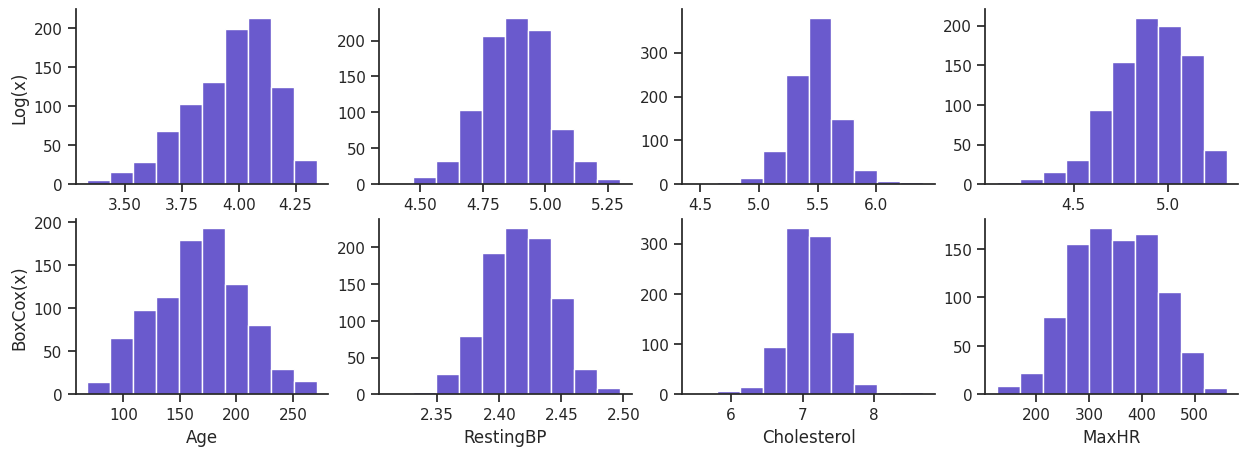

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (15, 5))

for i in range(4):
  ax[0, i].hist(np.log(data[col_num.columns[i]]), color = 'slateblue')
  ax[1, i].hist(stats.boxcox(data[col_num.columns[i]])[0], color = 'slateblue')
  ax[1, i].set_xlabel(col_num.columns[i])
  ax[1, i].spines[['top', 'right']].set_visible(False)
  ax[0, i].spines[['top', 'right']].set_visible(False)

ax[0, 0].set_ylabel("Log(x)")
ax[1, 0].set_ylabel("BoxCox(x)")
plt.show()

### ANOVAS

In [ ]:
col_cat['Sex'].unique()

array(['M', 'F'], dtype=object)

In [ ]:
Ps = np.zeros((5, 6))

In [ ]:
d1 = data[data['Sex'] == 'M']['Age']
d2 = data[data['Sex'] == 'F']['Age']

stats.kruskal(d1, d2)

KruskalResult(statistic=3.294587654964763, pvalue=0.06950855823196136)

In [ ]:
for i in range(5):
  for j in range(6):
    num = col_num.columns[i]
    cat = col_cat.columns[j]
    grupos = []
    for k in col_cat[cat].unique():
      d = data[data[cat] == k][num]
      grupos.append(d)
    prueba = stats.kruskal(*grupos)
    Ps[i, j] = prueba[1]

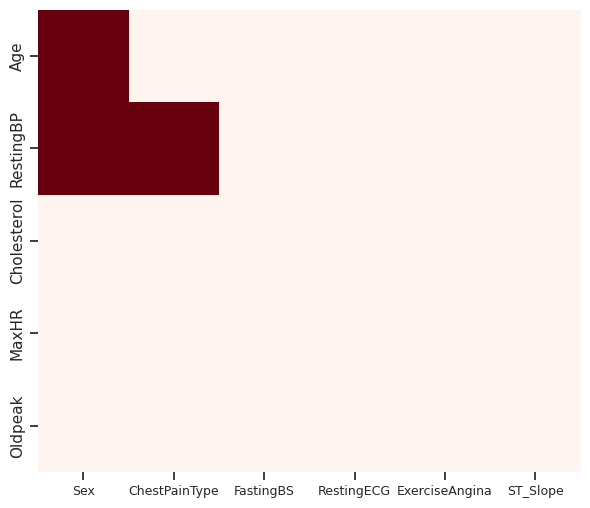

In [ ]:
fig, ax = plt.subplots(figsize = (7, 6))

sns.heatmap(Ps>0.05, cmap = "Reds", cbar=False, ax = ax)
ax.set_yticklabels(col_num.columns)
ax.set_xticklabels(col_cat.columns, fontsize = 9)

plt.show()

La transformación abrió el número de categorías a 918 columnas. Se usa MCA para reducir tal número.

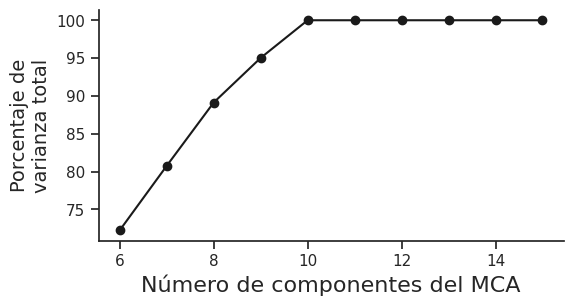

In [ ]:
varianzas = []

for i in range(len(col_cat.columns), len(col_cat.columns) + 10):
  # instantiate MCA class
  mca = prince.MCA(n_components = i)

  # get principal components
  mca = mca.fit(col_cat)
  varianzas.append(mca.eigenvalues_summary.iloc[:, 1].apply(lambda x: float(x[:-1])).sum())

fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(range(len(col_cat.columns), len(col_cat.columns) + 10), varianzas, marker = 'o', color = 'k')
ax.set_xlabel('Número de componentes del MCA', fontsize = 16)
ax.set_ylabel('Porcentaje de\nvarianza total', fontsize = 14)
ax.spines[['top', 'right']].set_visible(False)

plt.show()

In [ ]:
mca = prince.MCA(n_components = 10).fit(col_cat)
new_cats = mca.transform(col_cat)

In [ ]:
mca.column_contributions_.sort_values(by=0, ascending = False)

,0,1,2,3,4,5,6,7,8,9
ExerciseAngina_Y,0.162995,0.030905,0.012108,0.008999,4.219613e-03,0.008321,1.522026e-03,0.012640,0.025178,0.328973
ST_Slope_Up,0.153197,0.000096,0.028892,0.000394,1.542270e-03,0.000028,2.286212e-02,0.018582,0.158156,0.185967
ChestPainType_ATA,0.140102,0.056132,0.086672,0.076909,9.993677e-04,0.024618,2.142474e-04,0.049043,0.373794,0.003064
ExerciseAngina_N,0.110550,0.020961,0.008213,0.006104,2.861931e-03,0.005644,1.032306e-03,0.008573,0.017077,0.223124
ChestPainType_ASY,0.108326,0.021972,0.000064,0.032357,5.379706e-11,0.007051,4.987788e-03,0.009604,0.249916,0.025418
ST_Slope_Flat,0.090094,0.009488,0.065748,0.011150,8.668081e-02,0.002458,1.955245e-02,0.000328,0.104061,0.109351
Sex_F,0.072836,0.000909,0.044123,0.003535,5.373722e-03,0.229229,3.010265e-01,0.120992,0.008266,0.003471
FastingBS_1,0.045584,0.081756,0.151970,0.057369,2.292224e-03,0.007137,2.896391e-01,0.104099,0.001398,0.025640
ST_Slope_Down,0.028559,0.082810,0.071423,0.112260,4.861154e-01,0.014594,5.837889e-07,0.085512,0.015408,0.034691
RestingECG_ST,0.022346,0.003316,0.226337,0.086814,1.952600e-02,0.273956,9.791628e-02,0.068660,0.000173,0.007056


In [ ]:
names = {}
for i in range(10):
  names[i] = str(i)

new_cats.rename(columns = names, inplace = True)

In [ ]:
ABT = pd.concat([col_num, new_cats, data[['target']] ], axis = 1)

## Modelos

In [ ]:
ABT['target'] = pd.to_numeric(ABT['target'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ABT.drop(['target'], axis = 1), ABT['target'],
                                                    test_size=0.3, random_state=42)

In [ ]:
# Regresión Logística
log_r = LogisticRegression(solver = 'liblinear')
log_r.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Nearest Neighbor
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

# Support Vector Machine
svmc = SVC()
svmc.fit(X_train, y_train)

# Gradient Boost Classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

# Light GBM Classifier
lgbmc = lgb.LGBMClassifier()
lgbmc.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
def bootstrap_score(model, N = 1000):
  k = len(X_test)
  scores = np.zeros(N)
  for i in range(N):
    indexes = np.random.choice(X_test.index, size = k, replace = True)
    Xv = X_test.loc[indexes]
    Yv = y_test.loc[indexes]
    predicted = model.predict(Xv)
    mcc = metrics.matthews_corrcoef(Yv, predicted)
    scores[i] = mcc
  return scores

def score_models(models, N = 1000):
  k = len(models)
  scores = np.zeros((N, k))
  for i in range(k):
    X = bootstrap_score(models[i], N)
    scores[:, i] = X
  return scores

In [ ]:
Y = score_models([log_r, rf, nb, knc, svmc, gbc, lgbmc])

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.boxplot(Y, labels = ['Regresión\nLogística', 'Random\nForest', 'Naive\nBayes',
                        'K Neighbors', 'SVC', 'GBC', 'LGBMC'])
ax.set_title("Distribución del Coeficiente de Matthews\nn = 1000 iteraciones de bootstrap")

plt.show()

NameError: ignored

(array([ 14.,  47., 114., 199., 219., 199., 139.,  44.,  20.,   5.]),
 array([0.58920706, 0.61469985, 0.64019264, 0.66568543, 0.69117822,
        0.71667101, 0.7421638 , 0.76765659, 0.79314938, 0.81864217,
        0.84413496]),
 <BarContainer object of 10 artists>)

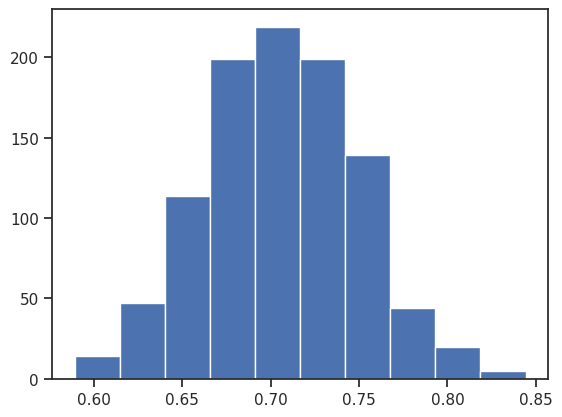

In [ ]:
plt.hist(Y)

In [ ]:
stats.shapiro(Y)

ShapiroResult(statistic=0.9981254935264587, pvalue=0.3392409682273865)

In [ ]:
def score(model):

    predicted = model.predict(X_test)
    ac = metrics.accuracy_score(y_test, predicted)
    f1 = metrics.f1_score(y_test, predicted)

    roc = metrics.roc_auc_score(y_test, predicted)


    return [ac, f1, mcc, roc]

In [ ]:
def calificar_modelos(n = 100):

  evaluaciones = []

  for i in range(n):


    scores = [score(log_r), score(rf), score(nb), score(knc), score(svmc), score(gbc), score(lgbmc)]

    evaluaciones.append(scores)

  return evaluaciones


In [ ]:
def calificar_modelos(n = 2000):

  evaluaciones = []

  for i in range(n):
    # Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Gradient Boost Classifier
    gbc = GradientBoostingClassifier()
    gbc.fit(X_train, y_train)

    scores = [score(rf), score(gbc)]

    evaluaciones.append(scores)

  return evaluaciones

In [ ]:
cal = calificar_modelos(2000)

In [ ]:
calf_modelos = np.zeros((7, 4))

for i in range(100):
  for j in range(7): # 7 modelos
    calf_modelo_j_iter_i = cal[i][j]
    calf_modelos[j] += calf_modelo_j_iter_i

promedio = calf_modelos



In [ ]:
C = np.array(cal)

In [ ]:
C[:, 0, 0]

array([0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
       0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956

In [ ]:
# modelos aleatorios:
alt = [1, 5]

In [ ]:
for i in alt:
  for j in range(4):
    print('calficiación ', j)
    print(stats.shapiro(C[:, i, j]))

calficiación  0
ShapiroResult(statistic=0.9744237661361694, pvalue=0.04863887280225754)
calficiación  1
ShapiroResult(statistic=0.9825882315635681, pvalue=0.21035541594028473)
calficiación  2
ShapiroResult(statistic=0.9901300072669983, pvalue=0.6751074194908142)
calficiación  3
ShapiroResult(statistic=0.9913745522499084, pvalue=0.7742934226989746)
calficiación  0
ShapiroResult(statistic=0.9114875793457031, pvalue=5.114890427648788e-06)
calficiación  1
ShapiroResult(statistic=0.9509180188179016, pvalue=0.0009539973107166588)
calficiación  2
ShapiroResult(statistic=0.9586402177810669, pvalue=0.003220495767891407)
calficiación  3
ShapiroResult(statistic=0.9603542685508728, pvalue=0.004262327682226896)


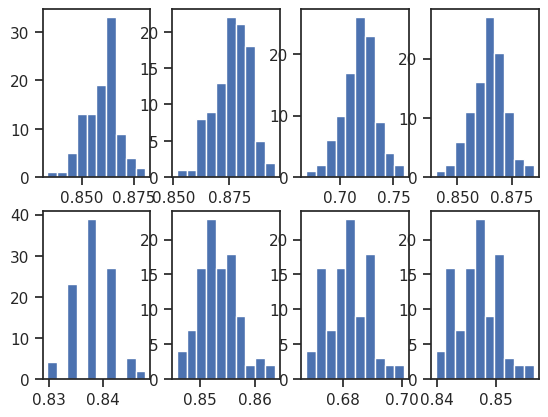

In [ ]:
fig, ax = plt.subplots(2, 4)

for j in range(4):
  ax[0, j].hist(C[:, 1, j])
  ax[1, j].hist(C[:, 5, j])

In [ ]:
df.columns = ['Accuracy', 'F1 Score', 'Matthews Coefficient', 'ROC auc']
df.index = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'kNN', 'SVC', 'GBC', 'LGBC']
df.sort_values(by = 'Matthews Coefficient', ascending = False)

,Accuracy,F1 Score,Matthews Coefficient,ROC auc
Logistic Regression,0.869565,0.886076,0.736949,0.873258
LGBC,0.865942,0.881789,0.732268,0.871625
Random Forest,0.859167,0.875927,0.718220,0.864352
Naive Bayes,0.844203,0.863492,0.685937,0.847670
GBC,0.836884,0.852865,0.680810,0.846451
SVC,0.706522,0.750769,0.394114,0.697844
kNN,0.673913,0.718750,0.331982,0.667574


#### Validación

In [ ]:
log_r = LogisticRegression(solver = 'liblinear')
log_r.fit(X_train, y_train)

lgbmc = lgb.LGBMClassifier()
lgbmc.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
col_cat

,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,0,Normal,N,Up
1,F,NAP,0,Normal,N,Flat
2,M,ATA,0,ST,N,Up
3,F,ASY,0,Normal,Y,Flat
4,M,NAP,0,Normal,N,Up
...,...,...,...,...,...,...
913,M,TA,0,Normal,N,Flat
914,M,ASY,1,Normal,N,Flat
915,M,ASY,0,Normal,Y,Flat
916,F,ATA,0,LVH,N,Flat


In [ ]:
cols = mca.column_contributions_.index.to_list()
cols

['Sex_F',
 'Sex_M',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'ChestPainType_TA',
 'FastingBS_0',
 'FastingBS_1',
 'RestingECG_LVH',
 'RestingECG_Normal',
 'RestingECG_ST',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up']

In [ ]:
x = data.iloc[[0], :].copy()
x['Age'] = 54
x['RestingBP'] = 132
x['Cholesterol'] = 244
x['FastingBS'] = '0'
x['RestingECG'] = 'Normal'
x['MaxHR'] = 137
x['Oldpeak'] = 0.887
x['ExerciseAngina'] = 'N'
x['ST_Slope'] = 'Flat'
x['ChestPainType'] = 'ASY'
# transformamos al correspondiente
y = col_cat.copy()
y.iloc[0, :] = ['M', 'ASY', '0', 'Normal', 'N', 'Flat']
yt = mca.transform(y).iloc[[0], :]
X = pd.concat([x[col_num.columns], yt], axis = 1)

In [ ]:
log_r.predict_proba(X.to_numpy())

array([[0.1865044, 0.8134956]])

In [ ]:
lgbmc.predict_proba(X.to_numpy())

array([[0.14246664, 0.85753336]])

#### Importancia de las columnas

In [ ]:
perm = PermutationImportance(log_r, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.3022 ± 0.0424,0
0.0159 ± 0.0126,4
0.0094 ± 0.0098,9
0.0043 ± 0.0096,MaxHR
0.0029 ± 0.0054,Cholesterol
0.0029 ± 0.0155,Oldpeak
0.0029 ± 0.0085,Age
0.0007 ± 0.0029,RestingBP
0 ± 0.0000,3
0.0000 ± 0.0079,1


In [ ]:
perm = PermutationImportance(lgbmc, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2775 ± 0.0345,0
0.0326 ± 0.0102,Oldpeak
0.0232 ± 0.0285,MaxHR
0.0203 ± 0.0074,6
0.0159 ± 0.0156,Age
0.0109 ± 0.0112,Cholesterol
0.0094 ± 0.0126,2
0.0080 ± 0.0141,7
0.0065 ± 0.0054,5
0.0058 ± 0.0134,4


In [ ]:
mca.column_contributions_.sort_values(by=0, ascending = False)

,0,1,2,3,4,5,6,7,8,9
ExerciseAngina_Y,0.162995,0.030905,0.012108,0.008999,4.219613e-03,0.008321,1.522026e-03,0.012640,0.025178,0.328973
ST_Slope_Up,0.153197,0.000096,0.028892,0.000394,1.542270e-03,0.000028,2.286212e-02,0.018582,0.158156,0.185967
ChestPainType_ATA,0.140102,0.056132,0.086672,0.076909,9.993677e-04,0.024618,2.142474e-04,0.049043,0.373794,0.003064
ExerciseAngina_N,0.110550,0.020961,0.008213,0.006104,2.861931e-03,0.005644,1.032306e-03,0.008573,0.017077,0.223124
ChestPainType_ASY,0.108326,0.021972,0.000064,0.032357,5.379706e-11,0.007051,4.987788e-03,0.009604,0.249916,0.025418
ST_Slope_Flat,0.090094,0.009488,0.065748,0.011150,8.668081e-02,0.002458,1.955245e-02,0.000328,0.104061,0.109351
Sex_F,0.072836,0.000909,0.044123,0.003535,5.373722e-03,0.229229,3.010265e-01,0.120992,0.008266,0.003471
FastingBS_1,0.045584,0.081756,0.151970,0.057369,2.292224e-03,0.007137,2.896391e-01,0.104099,0.001398,0.025640
ST_Slope_Down,0.028559,0.082810,0.071423,0.112260,4.861154e-01,0.014594,5.837889e-07,0.085512,0.015408,0.034691
RestingECG_ST,0.022346,0.003316,0.226337,0.086814,1.952600e-02,0.273956,9.791628e-02,0.068660,0.000173,0.007056


### Optimización de modelos campeones - Ajuste de hiperparemetros usando GridSearch
1. Regresión logística
2. LBGM Classifier

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [ ]:
# ABT['target'] = pd.to_numeric(ABT['target'])

In [ ]:
# from sklearn.model_selection import train_test_split
# X = ABT.drop('target',axis=1)
# y = ABT.target

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Definir los hiperparámetros a ajustar y sus rangos
hyperparameters = {
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
}

In [ ]:
# Crear un objeto de clasificador LGBM
lgbm_classifier = lgb.LGBMClassifier()

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
gs_lgbmc = GridSearchCV(lgbm_classifier, hyperparameters, cv=5)

# Ajustar el modelo a los datos de entrenamiento
gs_lgbmc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [10, 20, 30]})

In [ ]:
# Obtener los mejores hiperparámetros y el mejor modelo
best_params = gs_lgbmc.best_params_
best_model = gs_lgbmc.best_estimator_

# Evaluar el modelo con los datos de prueba
accuracy = best_model.score(X_test, y_test)

In [ ]:
print("Mejores hiperparámetros:", best_params)
print("Exactitud del modelo:", accuracy)

Mejores hiperparámetros: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20}
Exactitud del modelo: 0.8768115942028986


In [ ]:
df = {'LGBMC Hiperparametros': score(gs_lgbmc), 'LGBMC Original' : score(lgbmc)}

df = pd.DataFrame(df)
df.index = ['Accuracy', 'F1 Score', 'Matthews Coefficient', 'ROC auc']
df.transpose()

,Accuracy,F1 Score,Matthews Coefficient,ROC auc
LGBMC Hiperparametros,0.876812,0.892405,0.751782,0.880771
LGBMC Original,0.865942,0.881789,0.732268,0.871625


1. Regresión lineal

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
ABT['target'] = pd.to_numeric(ABT['target'])

In [ ]:
from sklearn.model_selection import train_test_split
X = ABT.drop('target',axis=1)
y = ABT.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Definir los hiperparámetros a ajustar y sus rangos
hyperparameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10, 100]
}

In [ ]:
# Crear un objeto de regresión logística
logistic_regression = LogisticRegression()

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
gs_log_r = GridSearchCV(logistic_regression, hyperparameters, cv=10)

# Ajustar el modelo a los datos de entrenamiento
gs_log_r.fit(X_train, y_train)



GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet']})

In [ ]:
# Obtener los mejores hiperparámetros y el mejor modelo
best_params = gs_log_r.best_params_
best_model = gs_log_r.best_estimator_

# Evaluar el modelo con los datos de prueba
accuracy = best_model.score(X_test, y_test)

In [ ]:
print("Mejores hiperparámetros:", best_params)
print("Exactitud del modelo:", accuracy)

Mejores hiperparámetros: {'C': 1, 'penalty': 'l2'}
Exactitud del modelo: 0.8768115942028986


In [ ]:
df = {'Log R Hiperparametros': score(gs_log_r), 'Log R Original' : score(log_r)}

df = pd.DataFrame(df)
df.index = ['Accuracy', 'F1 Score', 'Matthews Coefficient', 'ROC auc']
df.transpose()

,Accuracy,F1 Score,Matthews Coefficient,ROC auc
Log R Hiperparametros,0.876812,0.893082,0.750182,0.879355
Log R Original,0.869565,0.886076,0.736949,0.873258


###  Resultados del ajuste de hiperparametros

In [ ]:
df = {'LGBMC Hiperparametros': score(gs_lgbmc), 'LGBMC Original' : score(lgbmc), 'Log R Hiperparametros': score(gs_log_r), 'Log R Original' : score(log_r)}

df = pd.DataFrame(df)
df.index = ['Accuracy', 'F1 Score', 'Matthews Coefficient', 'ROC auc']
df.transpose()


,Accuracy,F1 Score,Matthews Coefficient,ROC auc
LGBMC Hiperparametros,0.876812,0.892405,0.751782,0.880771
LGBMC Original,0.865942,0.881789,0.732268,0.871625
Log R Hiperparametros,0.876812,0.893082,0.750182,0.879355
Log R Original,0.869565,0.886076,0.736949,0.873258


#### Validación

In [ ]:
x = data.iloc[[0], :].copy()
x['Age'] = 54
x['RestingBP'] = 132
x['Cholesterol'] = 244
x['FastingBS'] = '0'
x['RestingECG'] = 'Normal'
x['MaxHR'] = 137
x['Oldpeak'] = 0.887
x['ExerciseAngina'] = 'N'
x['ST_Slope'] = 'Flat'
x['ChestPainType'] = 'ASY'
# transformamos al correspondiente
y = col_cat.copy()
y.iloc[0, :] = ['M', 'ASY', '0', 'Normal', 'N', 'Flat']
yt = mca.transform(y).iloc[[0], :]
X = pd.concat([x[col_num.columns], yt], axis = 1)

In [ ]:
gs_lgbmc.predict_proba(X.to_numpy())

array([[0.22604386, 0.77395614]])

In [ ]:
gs_log_r.predict_proba(X.to_numpy())

array([[0.19230656, 0.80769344]])

### Matriz confusión LGBMC

In [ ]:
# Predict the results
y_hat = gs_lgbmc.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confussion matrix
cm = confusion_matrix(y_test, y_hat)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[101  11]
 [ 23 141]]

True Positives(TP) =  101

True Negatives(TN) =  141

False Positives(FP) =  11

False Negatives(FN) =  23


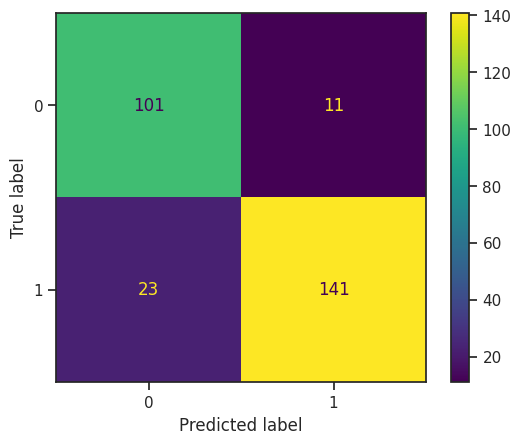

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_lgbmc.classes_).plot()

### Matriz confusión Regresión lineal

In [ ]:
# Predict the results
y_hat = gs_log_r.predict(X_test)


In [ ]:
# Confussion matrix
cm = confusion_matrix(y_test, y_hat)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[100  12]
 [ 22 142]]

True Positives(TP) =  100

True Negatives(TN) =  142

False Positives(FP) =  12

False Negatives(FN) =  22


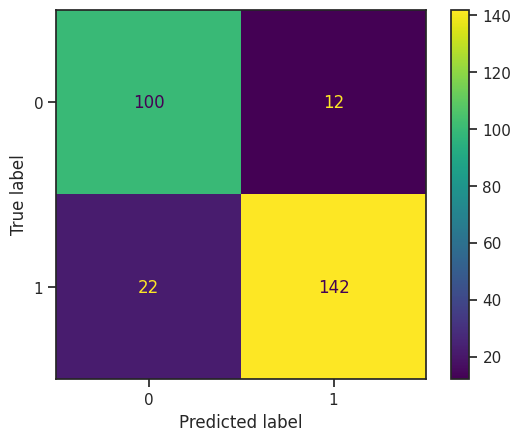

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=gs_lgbmc.classes_).plot()